In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
import time

In [ ]:
!pip install umap-learn[plot]

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import umap
import seaborn as sns

In [ ]:
from google.colab import drive
#@title 1.2 Prepare Folders
#@markdown If you connect your Google Drive, you can save the final image of each run on your drive.

google_drive = True #@param {type:"boolean"}

#@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
yes_please = True #@param {type:"boolean"}

if google_drive is True:
  drive.mount('/content/drive')
 
else:
  root_path = '/content'

Mounted at /content/drive


# 00 LOADING DATASET 
KINEMATICS 
DATASET CONTAINS SEVERAL RECORDINGS OF SENSORS BASED ON CELL PHONE DATA TO DETERMINE ACTIVITY BETWEEN RUNNING AND WALKING.

In [ ]:
root = "/content/drive/MyDrive/Archi_Dataset/Data Kinematics"

In [ ]:
data_path = "Kinematics_Data.csv"

fullpath = os.path.join(root,data_path)

In [ ]:

df = pd.read_csv(fullpath)


In [ ]:
df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


### activity classifier
two classes 0 = walking 1 = running 

In [ ]:
df.activity.unique()
df.shape

(88588, 11)

In [ ]:
df_clean = df.drop(['username','date'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
df_clean

,time,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,13:51:15:847724020,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,13:51:16:246945023,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,13:51:16:446233987,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,13:51:16:646117985,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,13:51:16:846738994,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
...,...,...,...,...,...,...,...,...,...
88583,20:9:15:317911028,0,0,0.3084,-0.8376,-0.1327,0.4823,2.0124,0.6048
88584,20:9:15:517889022,0,0,0.4977,-1.0027,-0.4397,0.1022,-1.2565,-0.0761
88585,20:9:15:717828989,0,0,0.4587,-1.1780,-0.2827,-1.4500,-0.2792,-1.2616
88586,20:9:15:917932987,0,0,0.2590,-0.8582,-0.0759,-1.5165,0.4560,-1.7755


In [ ]:
df_y = df_clean['activity']
df_x = df_clean.drop(['activity','time'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
df_x

,wrist,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
...,...,...,...,...,...,...,...
88583,0,0.3084,-0.8376,-0.1327,0.4823,2.0124,0.6048
88584,0,0.4977,-1.0027,-0.4397,0.1022,-1.2565,-0.0761
88585,0,0.4587,-1.1780,-0.2827,-1.4500,-0.2792,-1.2616
88586,0,0.2590,-0.8582,-0.0759,-1.5165,0.4560,-1.7755


In [ ]:
df_y

0        0
1        0
2        0
3        0
4        0
        ..
88583    0
88584    0
88585    0
88586    0
88587    0
Name: activity, Length: 88588, dtype: int64

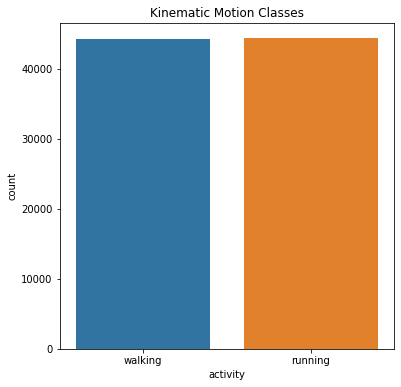

In [ ]:
###count of classes
plt.figure(figsize=(6,6))
g = sns.countplot(x = df_y)
plt.title('Kinematic Motion Classes')

g.set_xticklabels(['walking', 'running'])
plt.show()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


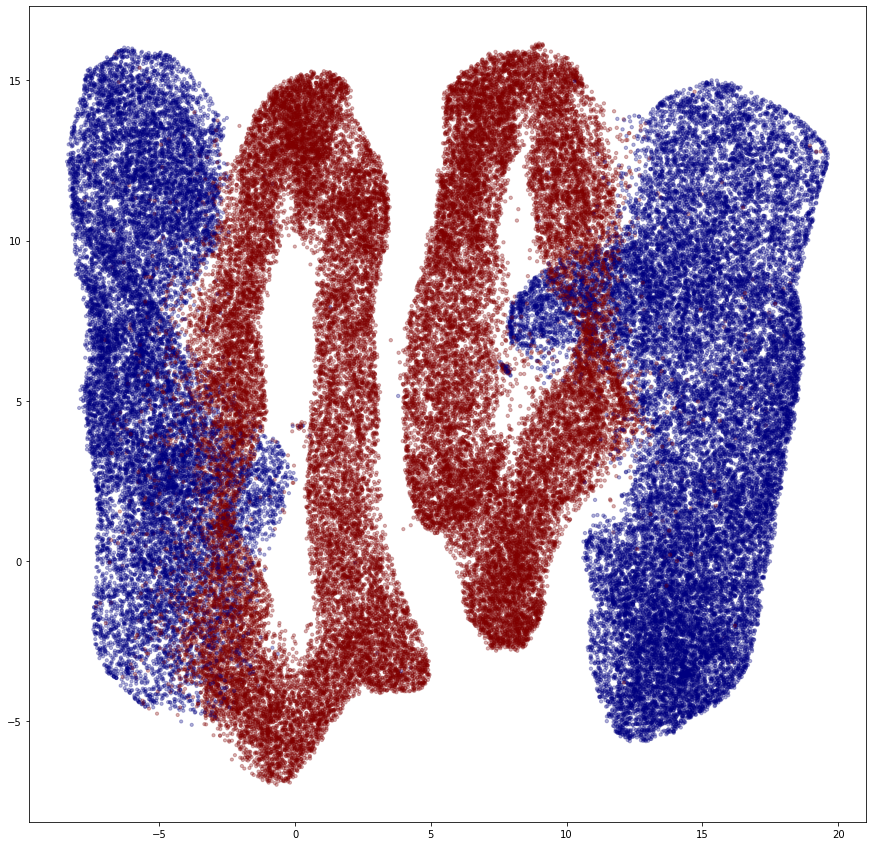

In [ ]:
fit = umap.UMAP(
    n_neighbors = 20,
    min_dist = 0.5,
    n_components=2,
    metric ='euclidean'
)
plt.figure(figsize=(15,15))
ax = plt.gca()
u = fit.fit_transform(df_x)
ax.scatter(u[:,0], u[:,1],c = df_y,s= df_x['wrist'] + 10, alpha=.3, cmap='jet')

In [ ]:
# first ten features
data_dia = df_y
data = df_x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([df_y,data_n_2.iloc[:,:]],axis=1)
data.head()

,activity,wrist,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0,-1.045362,0.336681,-0.332314,0.629308,-0.050390,-0.003924,-1.541941
1,0,-1.045362,0.740129,-0.851558,0.163422,-0.143495,-0.013684,0.054624
2,0,-1.045362,0.509969,-1.395860,0.793230,-0.729730,0.057642,-1.284474
3,0,-1.045362,0.374430,-0.379546,0.827330,0.092339,-0.372982,-1.544030
4,0,-1.045362,0.551087,-0.559815,0.718664,0.038726,0.334269,1.290139


In [ ]:
data = pd.melt(data,id_vars="activity",
                    var_name="features",
                    value_name='value')

In [ ]:
data.head()

,activity,features,value
0,0,wrist,-1.045362
1,0,wrist,-1.045362
2,0,wrist,-1.045362
3,0,wrist,-1.045362
4,0,wrist,-1.045362


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

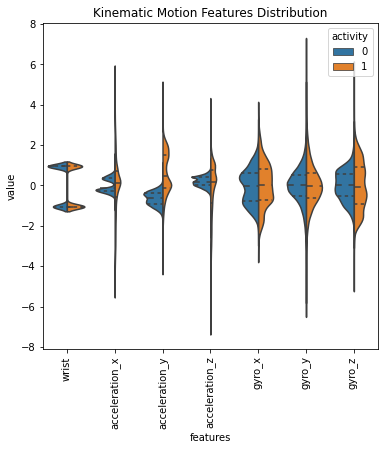

In [ ]:
plt.figure(figsize=(6,6))
g = sns.violinplot(x="features", y="value",hue = "activity", data=data,split=True, inner="quart")
plt.title('Kinematic Motion Features Distribution')
plt.xticks(rotation=90)

In [ ]:
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

# 01 DECISION TREES

In [ ]:
def decisiontrees(df_x, df_y, impurity):
    #impurity = 'gini' or 'entropy'
    
    max_depth_range = list(range(1, 20))
    
    results_dict = {}

    runs = 5

    test_scores = []
    acc = np.zeros([runs,len(max_depth_range)])
    times = np.zeros([runs,len(max_depth_range)])

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y)

            accuracy = []
            start_time = time.time()
            for d,depth in enumerate(max_depth_range):
                
                clf = DecisionTreeClassifier(max_depth = depth,criterion=impurity, random_state = 0)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                accuracy.append(score)
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time 
            #results_dict[depth] = {"accuracy": accuracy}
            test_scores.append(accuracy)

            pbar.update()


  
    return acc, times, clf 

In [ ]:
trees_acc, times, clf = decisiontrees(df_x, df_y, 'gini')

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
classes = np.unique(df_y)

In [ ]:
x = df_x.to_numpy()

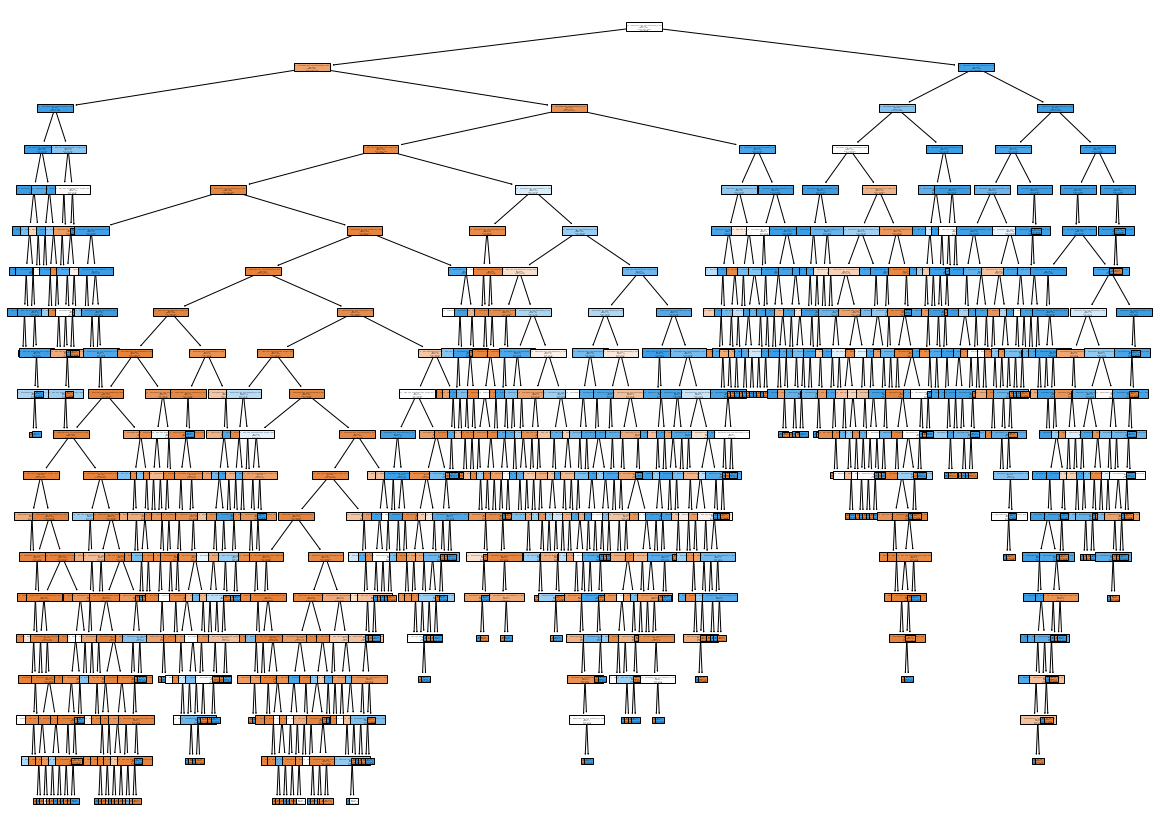

In [ ]:
plt.figure(figsize=(20,15))
features = x
classes = ['walking','running']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [ ]:
trees_acc 

array([[0.8490089 , 0.91773152, 0.94626812, 0.95900122, 0.9682124 ,
        0.97448864, 0.97683659, 0.97819118, 0.97846209, 0.97963607,
        0.98261616, 0.98342891, 0.9833386 , 0.98320314, 0.98374498,
        0.98419651, 0.98455773, 0.98451258, 0.98446742],
       [0.84648034, 0.91831851, 0.94595205, 0.95931729, 0.96920576,
        0.97494017, 0.9770172 , 0.97742358, 0.97900393, 0.98049397,
        0.9818034 , 0.98338375, 0.98397074, 0.98388044, 0.98379013,
        0.98451258, 0.9856414 , 0.98568655, 0.98604777],
       [0.84842191, 0.91845397, 0.94735179, 0.95809816, 0.96780602,
        0.97466926, 0.9762496 , 0.9785524 , 0.9794103 , 0.97968122,
        0.98139703, 0.98189371, 0.98234524, 0.98261616, 0.98306768,
        0.98293223, 0.9833386 , 0.98306768, 0.98397074],
       [0.84964103, 0.9181379 , 0.94667449, 0.95737572, 0.96803179,
        0.97412742, 0.97593354, 0.97760419, 0.97810087, 0.97904908,
        0.9809455 , 0.98157764, 0.98202917, 0.98279677, 0.98297738,
        0.983

In [ ]:
max_depth_range = list(range(1, 20))

acc_plot = []
for t in trees_acc:
  for i,d in enumerate(max_depth_range):
    points = [t[i],d]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)

In [ ]:
df_acc = pd.DataFrame(acc_plot)
df_acc

,0,1
0,0.849009,1.0
1,0.917732,2.0
2,0.946268,3.0
3,0.959001,4.0
4,0.968212,5.0
...,...,...
90,0.983700,15.0
91,0.984422,16.0
92,0.984648,17.0
93,0.984693,18.0


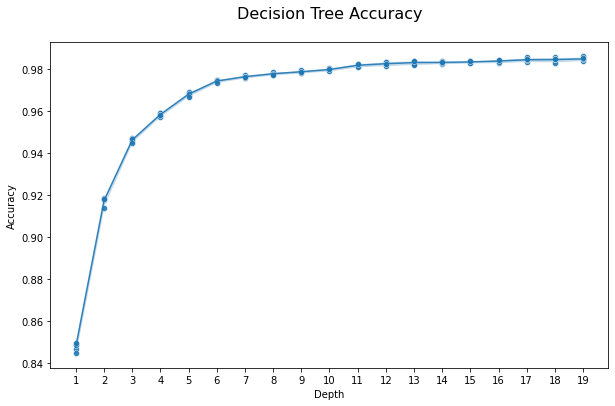

In [ ]:
fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Depth")
ax.set_ylabel("Accuracy")
ax.set_title(f"Decision Tree Accuracy\n",fontsize = 16)
ax.set_xticks(max_depth_range)
ax.set_xticklabels(max_depth_range)
plt.show()

In [ ]:
max_depth_range = list(range(1, 20))

t_plot = []
for t in times:
  for i,d in enumerate(max_depth_range):
    points = [t[i],d]
    t_plot.append(points)
t_plot = np.array(t_plot)

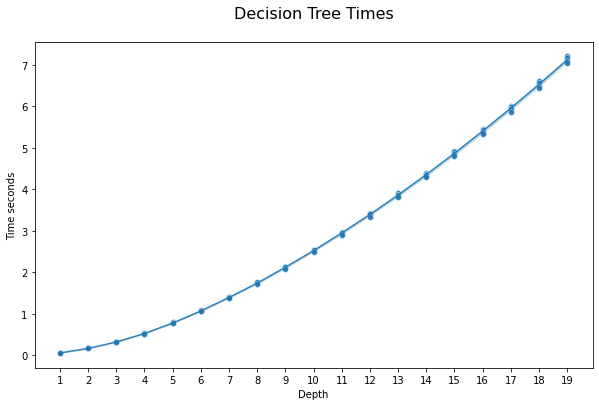

In [ ]:
fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=t_plot[:,1],y=t_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=t_plot[:,1],y=t_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Depth")
ax.set_ylabel("Time seconds")
ax.set_title(f"Decision Tree Times\n",fontsize = 16)
ax.set_xticks(max_depth_range)
ax.set_xticklabels(max_depth_range)
plt.show()

In [ ]:
path = clf.cost_complexity_pruning_path(x,df_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.00000000e+00 1.60558601e-07 1.63375175e-07 5.18950465e-07
 6.62241688e-06 7.52132060e-06 7.81953975e-06 8.06300757e-06
 9.83405001e-06 9.87718427e-06 1.00339650e-05 1.01593895e-05
 1.01593895e-05 1.01593895e-05 1.01593895e-05 1.02620096e-05
 1.02620096e-05 1.03475264e-05 1.04198867e-05 1.04819098e-05
 1.05356632e-05 1.05356632e-05 1.05826974e-05 1.06610878e-05
 1.06610878e-05 1.07506768e-05 1.08178685e-05 1.08595444e-05
 1.08701287e-05 1.08989620e-05 1.08989620e-05 1.09455826e-05
 1.09461436e-05 1.09562044e-05 1.09831238e-05 1.09881866e-05
 1.09911524e-05 1.10094893e-05 1.10968850e-05 1.11031580e-05
 1.11031580e-05 1.11154319e-05 1.11246133e-05 1.11416105e-05
 1.11416105e-05 1.11522081e-05 1.11554081e-05 1.11883149e-05
 1.12058149e-05 1.12139460e-05 1.12163112e-05 1.12193800e-05
 1.12437104e-05 1.12492857e-05 1.12530448e-05 1.12654521e-05
 1.12706129e-05 1.12718097e-05 1.12741355e-05 1.12758128e-05
 1.12778259e-05 1.12842609e-05 1.12882106e-05 1.12882106e-05
 1.12882106e-05 1.128821

In [ ]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x, df_y)
    clfs.append(clf)

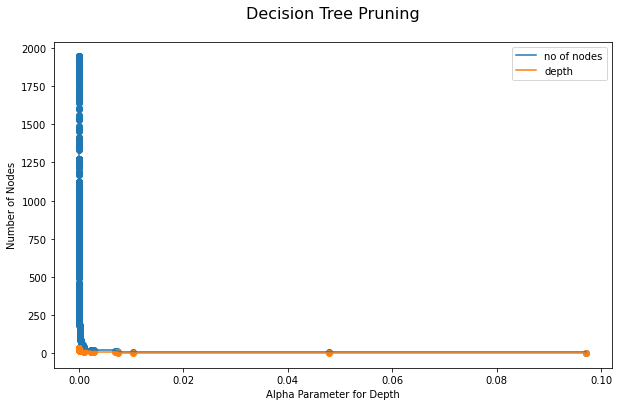

In [ ]:
fig, (ax) = plt.subplots(1,figsize=(10,6))
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

ax.scatter(ccp_alphas,node_counts)
ax.scatter(ccp_alphas,depth)
ax.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
ax.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
ax.legend()
ax.set_xlabel("Alpha Parameter for Depth")
ax.set_ylabel("Number of Nodes")
ax.set_title(f"Decision Tree Pruning\n",fontsize = 16)

plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y)

In [ ]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,Y_train))
    test_acc.append(accuracy_score(y_test_pred,Y_test))



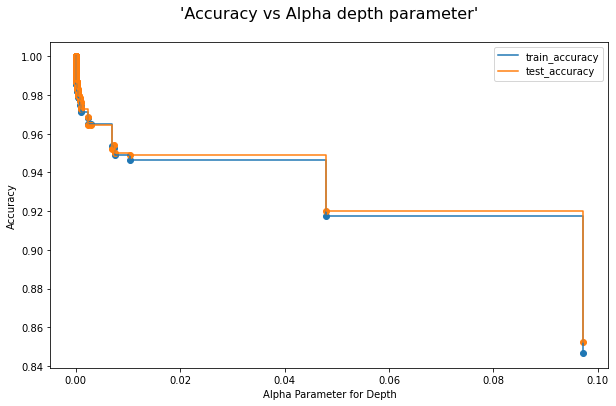

In [ ]:
fig, (ax) = plt.subplots(1,figsize=(10,6))
ax.scatter(ccp_alphas,train_acc)
ax.scatter(ccp_alphas,test_acc)
ax.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
ax.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
ax.legend()

ax.set_xlabel("Alpha Parameter for Depth")
ax.set_ylabel("Accuracy")
ax.set_title(f"'Accuracy vs Alpha depth parameter'\n",fontsize = 16)
plt.show()

Train score 0.9702141749823151
Test score 0.9697927484535152
Train Confusion matrix


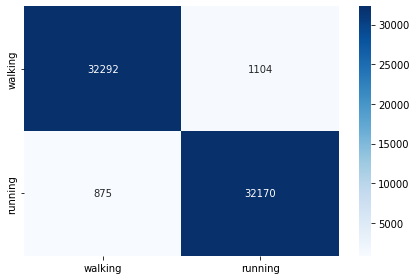

Test Confusion matrix


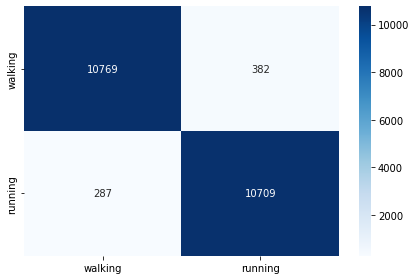

In [ ]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.002)
clf_.fit(X_train,Y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,Y_train)}')
print(f'Test score {accuracy_score(y_test_pred,Y_test)}')
plot_confusionmatrix(y_train_pred,Y_train,dom='Train')
plot_confusionmatrix(y_test_pred,Y_test,dom='Test')

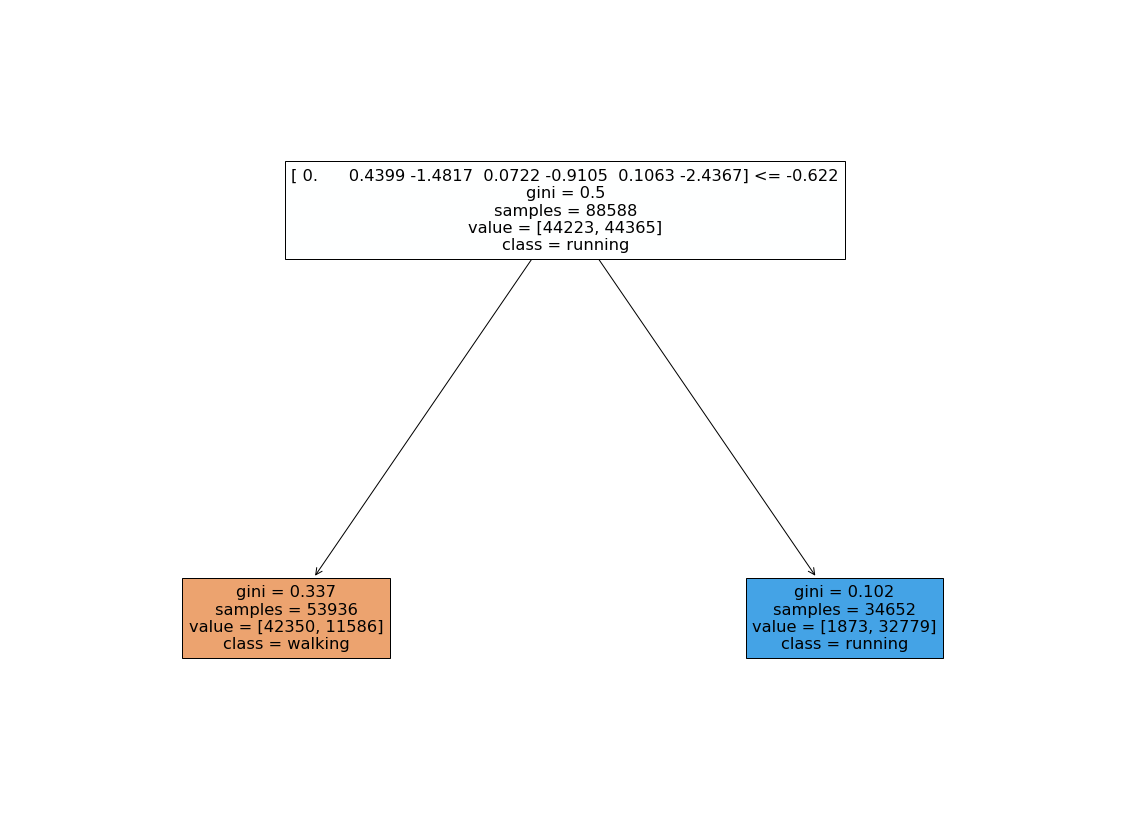

In [ ]:
plt.figure(figsize=(20,15))
features = x
classes = ['walking','running']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

# 02 BOOSTING TREES

In [ ]:
def boostingtrees(df_x, df_y):
    num_estimators = [10,20,50,100]
    test_scores = []
    runs = 5
    acc = np.zeros([runs,len(num_estimators)])
    times = np.zeros([runs,len(num_estimators)])
    #runs = 5

    test_scores = []

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y)
            
            accuracy = []
            start_time = time.time()
            for d,num_est in enumerate(num_estimators):
                clf = GradientBoostingClassifier(n_estimators=num_est, max_depth= 1)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                accuracy.append(score)
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time 

            test_scores.append(accuracy)

            pbar.update()
    
    return acc,times

In [ ]:
acc,times = boostingtrees(df_x, df_y)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
acc

array([[0.85076986, 0.91231318, 0.95173161, 0.96383257],
       [0.85167291, 0.92278864, 0.95118978, 0.96320043],
       [0.85135684, 0.9236917 , 0.94784847, 0.961891  ],
       [0.85316296, 0.91980855, 0.95218314, 0.96383257],
       [0.85180837, 0.91786698, 0.9524089 , 0.96405834]])

In [ ]:
times

array([[0.56589055, 1.65352345, 4.42094755, 9.70992517],
       [0.54843521, 1.63018107, 4.2884779 , 9.56480002],
       [0.55122018, 1.62176132, 4.25838923, 9.56156802],
       [0.55031157, 1.62333727, 4.27763939, 9.58729124],
       [0.55624056, 1.6394906 , 4.30843496, 9.64049101]])

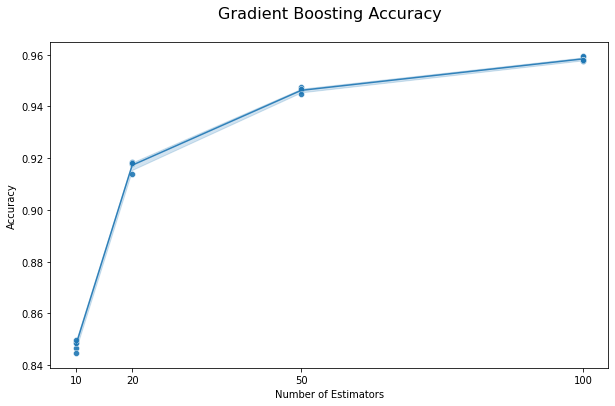

In [ ]:
num_estimators = [10,20,50,100]

acc_plot = []
for t in trees_acc:
  for i,d in enumerate(num_estimators):
    points = [t[i],d]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)
df_acc = pd.DataFrame(acc_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Accuracy")
ax.set_title(f"Gradient Boosting Accuracy\n",fontsize = 16)
ax.set_xticks(num_estimators)
ax.set_xticklabels(num_estimators)
plt.show()

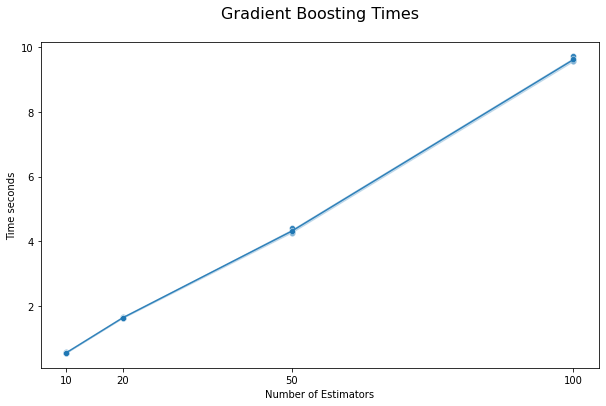

In [ ]:
num_estimators = [10,20,50,100]

t_plot = []
for t in times:
  for i,d in enumerate(num_estimators):
    points = [t[i],d]
    t_plot.append(points)
t_plot = np.array(t_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))
sns.lineplot(x=t_plot[:,1],y=t_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=t_plot[:,1],y=t_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Time seconds")
ax.set_title(f"Gradient Boosting Times\n",fontsize = 16)
ax.set_xticks(num_estimators)
ax.set_xticklabels(num_estimators)
plt.show()

# 03 KNN

In [ ]:
def knn(df_x, df_y):
    num_estimators = [2, 5, 10, 20, 50, 100]

    runs = 5
    acc = np.zeros([runs,len(num_estimators)])
    times = np.zeros([runs,len(num_estimators)])

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=.20)
            
            accuracy = []
            start_time = time.time()
            for d,num_est in enumerate(num_estimators):
                
                clf = KNeighborsClassifier(n_neighbors=num_est)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                accuracy.append(score)
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time 

          

            pbar.update()
    
    return  acc,times

In [ ]:
knn_acc, knn_times = knn(df_x, df_y)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def create_acc_plot(params, acc, title):
  num_estimators = params

  acc_plot = []
  for t in acc:
    for i,d in enumerate(num_estimators):
      points = [t[i],d]
      acc_plot.append(points)
  acc_plot = np.array(acc_plot)
  df_acc = pd.DataFrame(acc_plot)

  fig, (ax) = plt.subplots(1,figsize=(10,6))
  sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
  sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
  ax.set_xlabel("Number of Estimators")
  ax.set_ylabel("Accuracy")
  ax.set_title(f"{title}\n",fontsize = 16)
  ax.set_xticks(num_estimators)
  ax.set_xticklabels(num_estimators)
  plt.show()

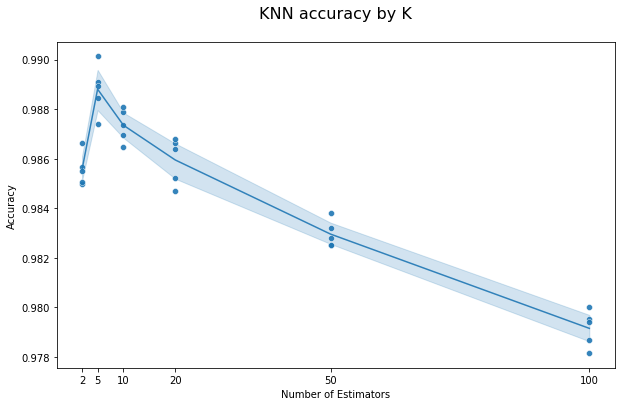

In [ ]:
num_estimators = [2, 5, 10, 20, 50, 100]

create_acc_plot(num_estimators,knn_acc,"KNN accuracy by K")

In [ ]:
knn_times.shape, knn_acc.shape

((5, 6), (5, 6))

In [ ]:
def create_time_plot(params,array,title):
  num_estimators = params

  t_plot = []
  for t in array:
    #print(t)
    for i,d in enumerate(num_estimators):
      points = [t[i],d]
      t_plot.append(points)
  t_plot = np.array(t_plot)

  fig, (ax) = plt.subplots(1,figsize=(10,6))
  sns.lineplot(x=t_plot[:,1],y=t_plot[:,0], alpha=0.9, ax = ax)
  sns.scatterplot(x=t_plot[:,1],y=t_plot[:,0],alpha=0.9,ax=ax)
  ax.set_xlabel("Number of Estimators")
  ax.set_ylabel("Time seconds")
  ax.set_title(f"{title}\n",fontsize = 16)
  ax.set_xticks(num_estimators)
  ax.set_xticklabels(num_estimators)
  plt.show()

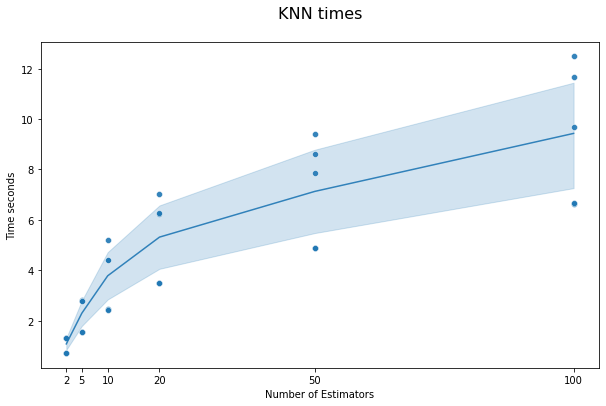

In [ ]:
create_time_plot(num_estimators,knn_times,"KNN times")

# 04 SVM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(df_x)
x = scaling.transform(df_x)

In [ ]:
def svmc(x,y):
    from sklearn.svm import SVC
    num_estimators = ['linear', 'poly', 'rbf', 'sigmoid']

    runs = 5
    acc = np.zeros([runs,len(num_estimators)])
    times = np.zeros([runs,len(num_estimators)])

    with tqdm(total=runs) as pbar:
        for n in range(runs):
            X_train, X_test, Y_train, Y_test = train_test_split(x, y)
            
            
            start_time = time.time()
            for d,num_est in enumerate(num_estimators):
                
                
                clf = SVC(kernel=num_est)
                clf.fit(X_train, Y_train)    
                score = clf.score(X_test, Y_test)
                
                acc[n,d] = score
                end_time = time.time()
                times[n,d] = end_time - start_time

            

            pbar.update()
    
    return acc,times, num_estimators

In [ ]:
svm_acc,svm_times, svm_num_estimators = svmc(x,df_y)

  0%|          | 0/5 [00:00<?, ?it/s]

[0.86616698 0.9809455  0.98627354 0.64162189]
[0.86634759 0.98175825 0.98627354 0.64406014]
[0.86246444 0.98130672 0.9864993  0.64040276]
[0.86431571 0.97954576 0.98469319 0.64437621]
[0.86160654 0.98139703 0.98654445 0.63959001]


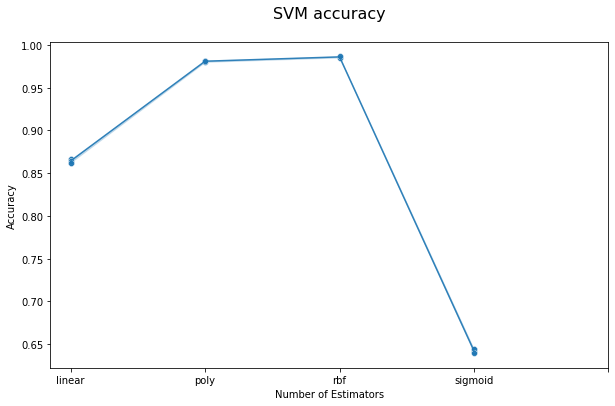

In [ ]:
title = 'SVM accuracy'
num_estimators = svm_num_estimators
acc = svm_acc
acc_plot = []
set_xticks = range(0,len(num_estimators)+1)
for t in acc:
  print(t)
  for i,d in enumerate(num_estimators):
    points = [t[i],i]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)
df_acc = pd.DataFrame(acc_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))


sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Accuracy")
ax.set_title(f"{title}\n",fontsize = 16)
ax.set_xticks(set_xticks)
ax.set_xticklabels(num_estimators)
plt.show()

[ 74.52186322  92.93829203 115.33237958 372.48724675]
[ 78.55941916 110.13363576 151.60804629 389.47792006]
[ 58.40080714  76.7365694   99.11517596 332.11276579]
[ 57.61741877  76.16092706  98.14972687 330.80736709]
[ 58.29342318  76.51677775  98.73492575 333.24691534]


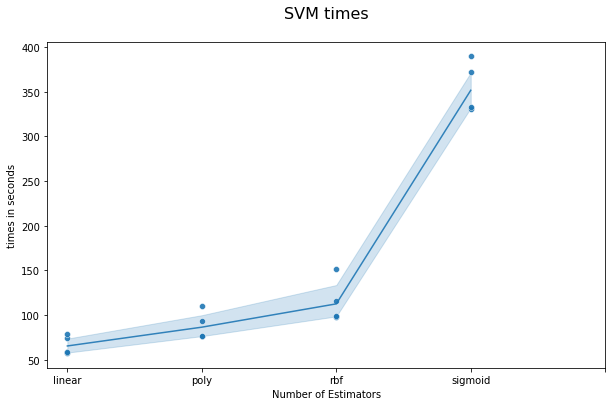

In [ ]:
title = 'SVM times'
num_estimators = svm_num_estimators
acc = svm_times
acc_plot = []
set_xticks = range(0,len(num_estimators)+1)
for t in acc:
  print(t)
  for i,d in enumerate(num_estimators):
    points = [t[i],i]
    acc_plot.append(points)
acc_plot = np.array(acc_plot)
df_acc = pd.DataFrame(acc_plot)

fig, (ax) = plt.subplots(1,figsize=(10,6))


sns.lineplot(x=acc_plot[:,1],y=acc_plot[:,0], alpha=0.9, ax = ax)
sns.scatterplot(x=acc_plot[:,1],y=acc_plot[:,0],alpha=0.9,ax=ax)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("times in seconds")
ax.set_title(f"{title}\n",fontsize = 16)
ax.set_xticks(set_xticks)
ax.set_xticklabels(num_estimators)
plt.show()

# 05 NN MLP

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Cuda Device Available")
  print("Name of the Cuda Device: ", torch.cuda.get_device_name())
  print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

Cuda Device Available
Name of the Cuda Device:  Tesla P100-PCIE-16GB
GPU Computational Capablity:  (6, 0)


In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.features = torch.Tensor(X_data).float()
        self.labels = torch.Tensor(y_data).long()
        self.size = len(self.labels)
        self.categories = len(np.unique(self.labels)) 
        
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
        
    def __len__ (self):
        return len(self.features)

In [ ]:
df_y.to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(df_x.to_numpy(), df_y.to_numpy(), test_size=0.2, )

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1)

train_set = ClassifierDataset(X_train, y_train)
val_set = ClassifierDataset(X_val, y_val)
test_set = ClassifierDataset(X_test, y_test)

In [ ]:
from collections import Counter

def class_count(datatype):
  count = Counter([target for target in datatype.ravel()])
  return count

val_count = class_count(y_val)
train_count = class_count(y_train)
test_count = class_count(y_test)

train_count, val_count, test_count

(Counter({0: 31878, 1: 31905}),
 Counter({0: 3520, 1: 3567}),
 Counter({0: 8825, 1: 8893}))

In [ ]:
class_count = [i for i in train_count.values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

target_list = []
for _, t in train_set:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

class_weights_all = class_weights[target_list]

weighted_sampler =  torch.utils.data.sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

tensor([3.1343e-05, 3.1370e-05])


In [ ]:
BATCH_SIZE = 64

## Load the Dataset
train_loader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE,sampler=weighted_sampler ,shuffle =False)
val_loader = DataLoader(dataset = val_set, batch_size = BATCH_SIZE, shuffle =False)
test_loader = DataLoader(dataset = test_set, batch_size = 1, shuffle =False)

In [ ]:
examples = iter(train_loader)
example_data, example_targets = examples.next()

In [ ]:
example_targets

tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_features=7, h1=10, h2=9, out_features=2):
        super().__init__()
        
        # input layer -> 1 hidden -> 2 hidden -> output 
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        # Pass the neuron input through its activation function to obtain the output of the neuron
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x





class Net(nn.Module):

    def __init__(self, inputs, outputs):
        super().__init__()

        self.fc1 = nn.Linear(inputs, 256)
        #self.b1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        #self.b2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128,64)
        #self.b3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64,outputs)
        #self.dropout = nn.Dropout(p=0.2)

    def forward(self,x):

        x = self.fc1(x)
        #x = self.b1(x)
        x = F.gelu(self.fc2(x))
        #x = self.dropout(x)
        #x = self.b2(x)
        x = F.gelu(self.fc3(x))
        #x = self.b3(x)
        #x = self.dropout(x)
        x = self.fc4(x)

        return x




In [ ]:
torch.manual_seed(4)
model = MLP().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
epochs = 500 # number of runs through the training data
losses = []
val_loss = []

for i in range(epochs):
    print(i)
    i+=1
    for x_train,y_train in train_loader:
      x_train, y_train = x_train.to(device), y_train.to(device)
      
      y_pred = model(x_train)
      loss = criterion(y_pred, y_train)
      losses.append(loss)
    
     

      optimizer.zero_grad() #zero-grad to not accomulate the gradient over the epochs
      loss.backward()
      optimizer.step()
      valid_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for data, labels in val_loader:
          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()
          
          target = model(data)
          loss = criterion(target,labels)
          valid_loss = loss.item() * data.size(0)
          val_loss.append(valid_loss)
      
      #print(f'epoch: {i}  loss: {loss:10.8f}')


In [124]:
path = "/content/drive/MyDrive/Archi_Dataset/Data/modelweights"
fullpath = os.path.join(path, 'mlp_weights.pt')
torch.save(model.state_dict(),fullpath)

In [128]:
losses_num = [i.detach().cpu().numpy() for i in losses]

In [136]:
n = 195
ls = [losses_num[i:i + n] for i in range(0, len(losses_num), n)]

In [139]:
len(ls)
ls = np.array(ls)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [153]:
len(val_loss)

21575517

In [148]:
len(ls[0])
train_loss = []
for j in range(len(ls)):
  average = np.sum(ls[j])/len(ls[j])
  train_loss.append(average)
  print(average)

0.09718369704026442
0.055190032567733374
0.04933996934157151
0.04383110144199469
0.035138575236002605
0.04456145457732372
0.033147163880177036
0.02888203645363832
0.04109678023900741
0.03245102319961939
0.03366663028032352
0.034371366256322616
0.026231709504738833
0.02974379612849309
0.03387248699481671
0.030588687994541265
0.03161838727119642
0.0352325317187187
0.03338411282270383
0.032393409044314654
0.02467354505490034
0.030417168446076222
0.02710575935168144
0.028555610852363782
0.028223561017941205
0.02841320771437425
0.024665392362154447
0.032739426539494444
0.030765220446464344
0.03385853889660958
0.026055785937187
0.02838930961413261
0.027140032939421826
0.02617616897974259
0.02620417766081981
0.022474259596604568
0.031082938267634464
0.02184882775331155
0.029121582324688252
0.025669024540827826
0.02560561742538061
0.0318450194138747
0.02594160911364433
0.02670138432429387
0.025612591474484175
0.026562289702586638
0.027883299803122496
0.02470232645670573
0.029869211637056792
0.

Text(0.5, 1.0, 'MLP training loss')

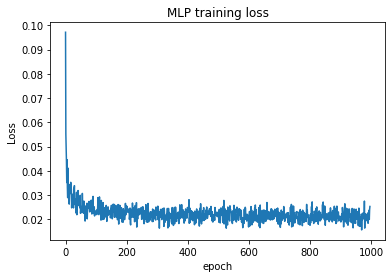

In [150]:
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('MLP training loss')

In [151]:
Test_Predictions = torch.max(y_pred,1)[1]
print(Test_Predictions)

tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')


In [152]:
with torch.no_grad():
    y_test_pred = model.forward(X_test)

TypeError: ignored

In [159]:
y_preds= []
y_trues = []

model.eval()     # Optional when not using Model Specific layer
for data, labels in test_loader:
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    y_pred= model.forward(data)
    y_test_pred = torch.max(y_pred,1)[1]
    y_preds.append(y_test_pred.detach().cpu().numpy())

    y_trues.append(labels.detach().cpu().numpy())
    


In [163]:
len(y_preds), len(y_trues)

(17718, 17718)

In [164]:
y1 = np.array(y_preds) 
yt = np.array(y_trues)

In [165]:
y1

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

Test Confusion matrix


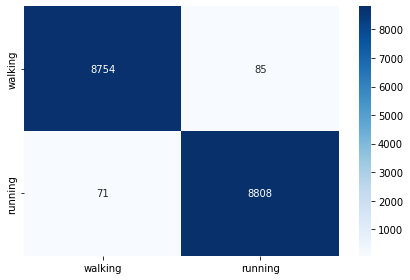

In [168]:

plot_confusionmatrix(y1,yt,dom='Test')

# 06 COMPILING DATA AND VIZ